In [38]:
# Importiamo le librerie necessarie
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic
import numpy as np

# Step 1: Importare il dataset con Pandas
# Carichiamo il dataset delle temperature globali
data = pd.read_csv("./GlobalTemperatures.csv")

# Step 2: Esplorare i dati
# Step 2.1. Visualizziamo le prime righe del dataset per avere un'idea del contenuto
print(data.head())
#           dt  AverageTemperature  AverageTemperatureUncertainty   City  \
# 0  1743-11-01               6.068                          1.737  Århus   
# 1  1743-12-01                 NaN                            NaN  Århus   
# 2  1744-01-01                 NaN                            NaN  Århus   
# 3  1744-02-01                 NaN                            NaN  Århus   
# 4  1744-03-01                 NaN                            NaN  Århus   

#    Country Latitude Longitude  
# 0  Denmark   57.05N    10.33E  
# 1  Denmark   57.05N    10.33E  
# 2  Denmark   57.05N    10.33E  
# 3  Denmark   57.05N    10.33E  
# 4  Denmark   57.05N    10.33E  

# Step 2.2. Per vedere tutte le città presenti nel dataset:
# creare un DataFrame con città uniche
unique_cities = data_cleaned[['City', 'Country']].drop_duplicates().reset_index(drop=True)

# Stampiamo l'elenco delle città
print("Numero totale di città uniche nel dataset:", len(unique_cities))
print(unique_cities)
# Numero totale di città uniche nel dataset: 3490

# Step 3: Pulizia del dataset

# Visualizzare il numero di valori mancanti per ciascuna colonna
print(data.isnull().sum())
# dt                                    0
# AverageTemperature               364130
# AverageTemperatureUncertainty    364130
# City                                  0
# Country                               0
# Latitude                              0
# Longitude                             0

# Rimuoviamo le righe con valori mancanti nelle colonne 'AverageTemperature' e 'AverageTemperatureUncertainty'
data_cleaned = data.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty'])

# Verifichiamo che i valori mancanti siano stati rimossi
print(data_cleaned.isnull().sum())
# dt                               0
# AverageTemperature               0
# AverageTemperatureUncertainty    0
# City                             0
# Country                          0
# Latitude                         0
# Longitude                        0

# Crea una copia esplicita del DataFrame pulito
data_cleaned = data.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty']).copy()

# Ora converti la colonna 'dt' in formato datetime senza warnings
data_cleaned['dt'] = pd.to_datetime(data_cleaned['dt'], errors='coerce')

# Verifica se ci sono valori nulli dopo la conversione
print(data_cleaned['dt'].isnull().sum())

# Verifica il tipo di dato della colonna 'dt'
print(data_cleaned.dtypes)

# dt                               datetime64[ns]
# AverageTemperature                      float64
# AverageTemperatureUncertainty           float64
# City                                     object
# Country                                  object
# Latitude                                 object
# Longitude                                object

# Conversione di Latitude e Longitude da object a float
# Funzione per convertire latitudine/longitudine in float
def convert_lat_lon(value):
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])
    return float(value)

# Applica la funzione alle colonne Latitude e Longitude
data_cleaned['Latitude'] = data_cleaned['Latitude'].apply(convert_lat_lon)
data_cleaned['Longitude'] = data_cleaned['Longitude'].apply(convert_lat_lon)

# Controlliamo che ora i tipi siano corretti
print(data_cleaned.dtypes)

# dt                               datetime64[ns]
# AverageTemperature                      float64
# AverageTemperatureUncertainty           float64
# City                                     object
# Country                                  object
# Latitude                                float64
# Longitude                               float64

# Estraiamo l'anno dalla colonna 'dt'
data_cleaned['Year'] = data_cleaned['dt'].dt.year

# Trova l'ultimo anno presente nel dataset
last_year = data_cleaned['Year'].max()
print(f"L'ultimo anno presente nel dataset è: {last_year}")
# L'ultimo anno presente nel dataset è: 2013
# La prima riga del dataset corrisponde al 1743
# Il periodo va dal 1743 al 2013

# Contiamo il numero di righe nel dataset
print(f"Il dataset contiene {data_cleaned.shape[0]} righe.")
# Il dataset contiene 8235082 righe.

           dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E  
Numero totale di città uniche nel dataset: 3490
         City      Country
0       Århus      Denmark
1       Çorlu       Turkey
2       Çorum       Turkey
3     Öskemen   Kazakhstan
4      Ürümqi        China
...       ...          ...
3485  Zouxian        China
3486    Zunyi        China
3487   Zurich  Switzerland
3488  Zuwarah        Libya
3489   Zwoll

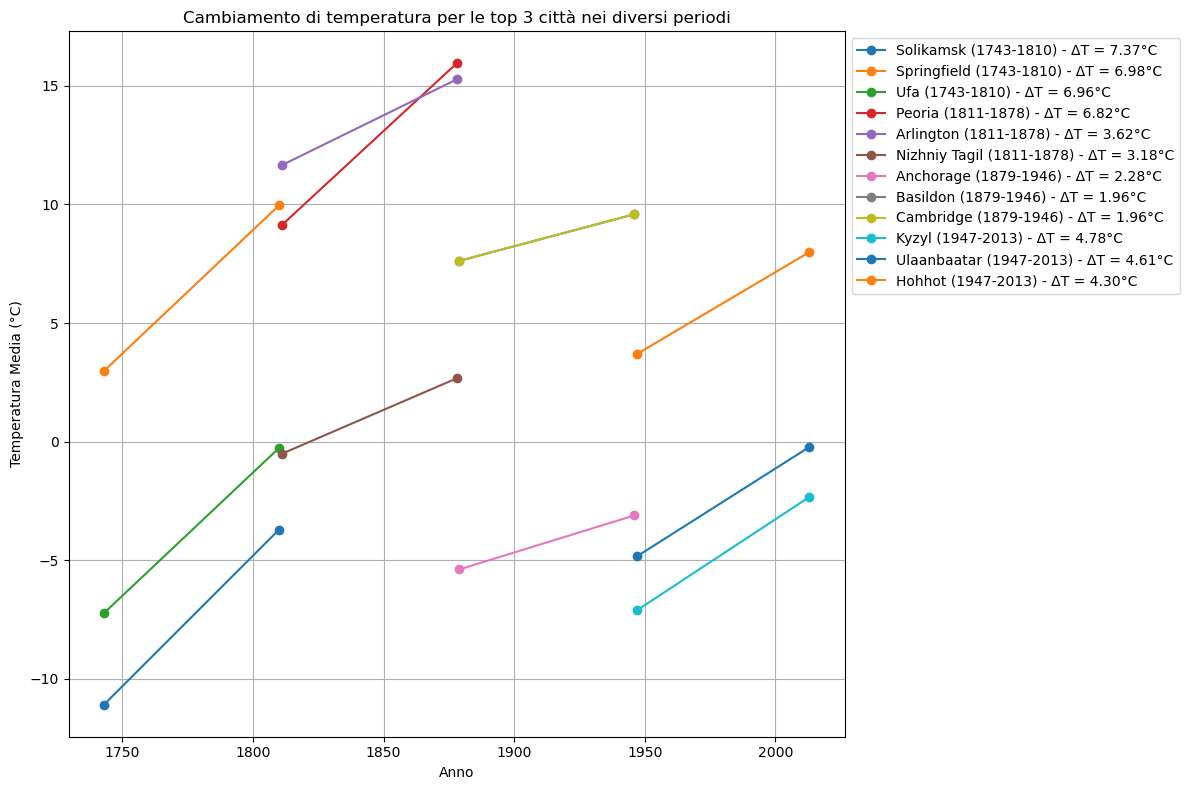

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calcolare la temperatura media per ogni città in ogni anno
data_cleaned['Year'] = data_cleaned['dt'].dt.year
yearly_avg_temp = data_cleaned.groupby(['City', 'Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Step 2: Dividere il periodo in 4 intervalli (1743-2013)
periods = {
    "1743-1810": (1743, 1810),
    "1811-1878": (1811, 1878),
    "1879-1946": (1879, 1946),
    "1947-2013": (1947, 2013)
}

# Step 3: Funzione per calcolare il cambiamento di temperatura per ogni periodo
def get_top_cities_for_period(start_year, end_year):
    # Filtrare i dati per il periodo specificato
    data_period = yearly_avg_temp[(yearly_avg_temp['Year'] >= start_year) & (yearly_avg_temp['Year'] <= end_year)]
    
    # Calcolare la temperatura media all'inizio e alla fine del periodo
    temp_start = data_period[data_period['Year'] == start_year].groupby(['City', 'Country'])['AverageTemperature'].mean().reset_index()
    temp_end = data_period[data_period['Year'] == end_year].groupby(['City', 'Country'])['AverageTemperature'].mean().reset_index()
    
    # Unire i dati per calcolare il cambiamento di temperatura
    temp_change = pd.merge(temp_start, temp_end, on=['City', 'Country'], suffixes=('_start', '_end'))
    temp_change['TemperatureChange'] = temp_change['AverageTemperature_end'] - temp_change['AverageTemperature_start']
    
    # Selezionare le 3 città con il maggiore cambiamento di temperatura
    top_3_cities = temp_change.nlargest(3, 'TemperatureChange')
    
    return top_3_cities

# Step 4: Trovare le top 3 città per ogni periodo
top_cities_by_period = {}
for period, (start_year, end_year) in periods.items():
    top_cities_by_period[period] = get_top_cities_for_period(start_year, end_year)

# Step 5: Creare un DataFrame unificato con i risultati
final_df = pd.concat(top_cities_by_period.values(), keys=top_cities_by_period.keys()).reset_index(level=0)
final_df.rename(columns={'level_0': 'Period'}, inplace=True)

# Step 6: Visualizzare il grafico
plt.figure(figsize=(12, 8))

# Creare un grafico per ciascun periodo con diverse città
for period, df in top_cities_by_period.items():
    for _, row in df.iterrows():
        # Calcolare il range di temperatura assoluto per ogni città
        temperature_range = abs(row['AverageTemperature_end'] - row['AverageTemperature_start'])
        
        # Disegna una linea dal periodo di inizio alla fine del periodo
        plt.plot(
            [periods[period][0], periods[period][1]],
            [row['AverageTemperature_start'], row['AverageTemperature_end']],
            marker='o',
            label=f"{row['City']} ({period}) - ΔT = {temperature_range:.2f}°C"
        )

# Step 7: Aggiungere dettagli al grafico
plt.title("Cambiamento di temperatura per le top 3 città nei diversi periodi")
plt.xlabel("Anno")
plt.ylabel("Temperatura Media (°C)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Mostrare il grafico
plt.show()


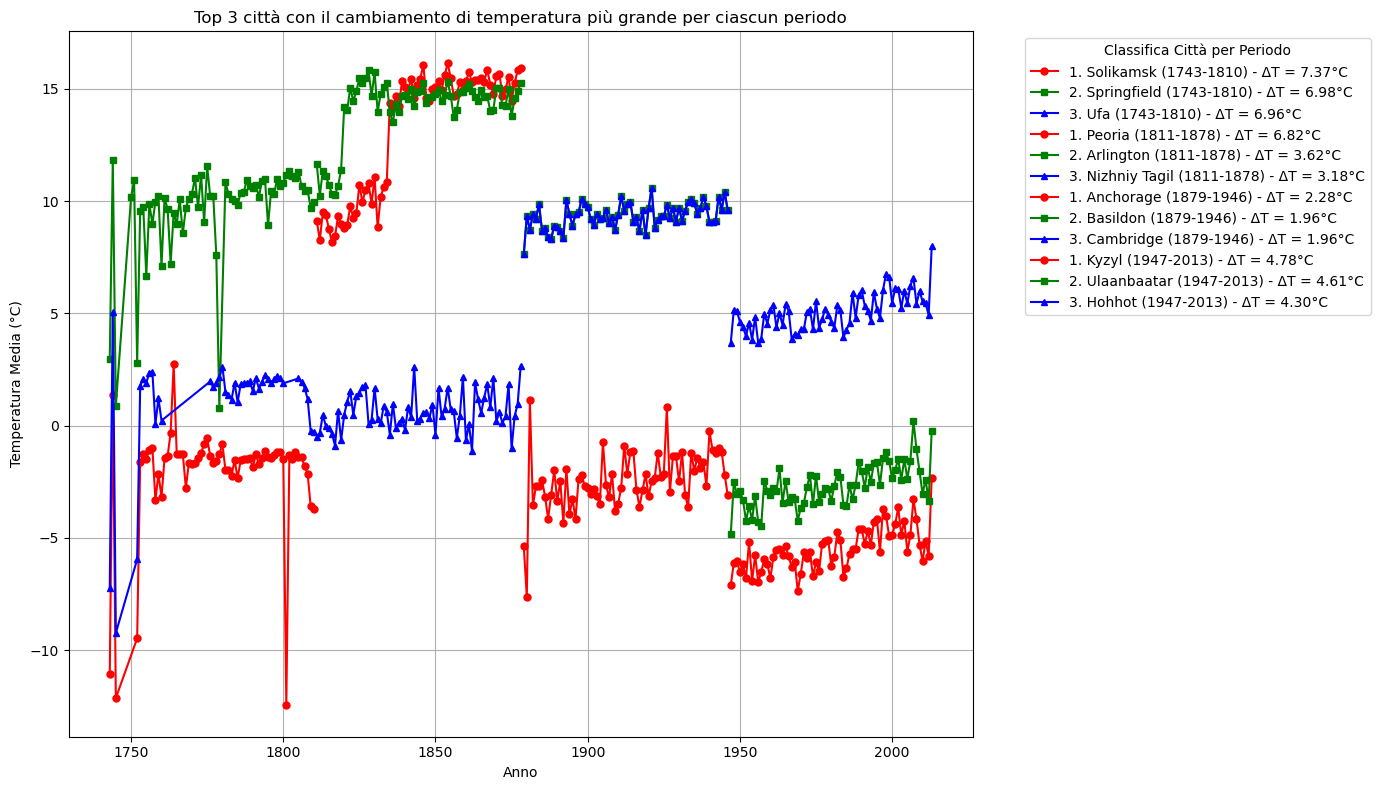

In [47]:
# Importiamo le librerie necessarie
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Caricare il dataset e fare la pulizia iniziale
data = pd.read_csv("./GlobalTemperatures.csv")
data_cleaned = data.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty']).copy()
data_cleaned['dt'] = pd.to_datetime(data_cleaned['dt'], errors='coerce')
data_cleaned['Latitude'] = data_cleaned['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1))
data_cleaned['Longitude'] = data_cleaned['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1))
data_cleaned['Year'] = data_cleaned['dt'].dt.year

# Step 2: Calcola la temperatura media annuale per ogni città
annual_avg_temp = data_cleaned.groupby(['City', 'Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Step 3: Definire i periodi
periods = {
    "1743-1810": (1743, 1810),
    "1811-1878": (1811, 1878),
    "1879-1946": (1879, 1946),
    "1947-2013": (1947, 2013)
}

# Step 4: Calcolare il cambiamento di temperatura per ciascun periodo e ottenere le 3 città con i maggiori cambiamenti
top_cities_by_period = {}

for period_name, (start_year, end_year) in periods.items():
    # Filtra i dati per il periodo specifico
    period_data = annual_avg_temp[(annual_avg_temp['Year'] >= start_year) & (annual_avg_temp['Year'] <= end_year)]
    
    # Calcola la temperatura media all'inizio e alla fine del periodo
    temp_start = period_data[period_data['Year'] == start_year].set_index(['City', 'Country'])['AverageTemperature']
    temp_end = period_data[period_data['Year'] == end_year].set_index(['City', 'Country'])['AverageTemperature']
    
    # Calcola il cambiamento di temperatura
    temp_change = (temp_end - temp_start).reset_index()
    temp_change.columns = ['City', 'Country', 'TemperatureChange']
    
    # Ordina per cambiamento di temperatura e prendi le prime 3 città
    top_cities = temp_change.nlargest(3, 'TemperatureChange')
    top_cities_by_period[period_name] = top_cities

# Step 5: Preparazione del grafico
plt.figure(figsize=(14, 8))

# Colori e markers per le città classificate (1°, 2°, 3°)
colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

# Step 6: Disegna le linee per ciascuna città e periodo
for i, (period_name, top_cities) in enumerate(top_cities_by_period.items()):
    for rank, (_, row) in enumerate(top_cities.iterrows()):
        city = row['City']
        country = row['Country']
        
        # Filtra i dati annuali per la città e il periodo corrente
        city_data = annual_avg_temp[(annual_avg_temp['City'] == city) & 
                                    (annual_avg_temp['Country'] == country) & 
                                    (annual_avg_temp['Year'] >= periods[period_name][0]) & 
                                    (annual_avg_temp['Year'] <= periods[period_name][1])]
        
        # Calcolare il range di temperatura assoluto
        temperature_range = abs(row['TemperatureChange'])
        
        # Plot della temperatura media annuale della città nel periodo
        plt.plot(city_data['Year'], city_data['AverageTemperature'], 
                 label=f"{rank + 1}. {city} ({period_name}) - ΔT = {temperature_range:.2f}°C", 
                 color=colors[rank], marker=markers[rank], 
                 markersize=5, linestyle='-', linewidth=1.5)

# Step 7: Personalizzazione del grafico
plt.title("Top 3 città con il cambiamento di temperatura più grande per ciascun periodo")
plt.xlabel("Anno")
plt.ylabel("Temperatura Media (°C)")
plt.legend(title="Classifica Città per Periodo", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()

# Step 8: Mostra il grafico
plt.show()


In [51]:
# Filtra i dati per Solikamsk
solikamsk_data = data_cleaned[data_cleaned['City'] == 'Solikamsk']

# Calcola la temperatura media per l'anno 1743
temp_1743 = solikamsk_data[solikamsk_data['Year'] == 1743]['AverageTemperature'].mean()

# Calcola la temperatura media per l'anno 1810
temp_1810 = solikamsk_data[solikamsk_data['Year'] == 1810]['AverageTemperature'].mean()

# Mostra i risultati
print(f"Temperatura media di Solikamsk nel 1743: {temp_1743:.2f} °C")
print(f"Temperatura media di Solikamsk nel 1810: {temp_1810:.2f} °C")

# Calcola il range di temperatura
temperature_range = temp_1810 - temp_1743
print(f"Il cambiamento di temperatura tra il 1743 e il 1810 è di: {temperature_range:.2f} °C")


Temperatura media di Solikamsk nel 1743: -11.09 °C
Temperatura media di Solikamsk nel 1810: -3.71 °C
Il cambiamento di temperatura tra il 1743 e il 1810 è di: 7.37 °C
